In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# function to convert TF tensor to Numpy array
def toNumpy(tf_tensor):
    
    session = tf.keras.backend.get_session()
    
    np_array = tf_tensor.eval(session=session)
    
    return np_array

In [20]:
# load data
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [24]:
# dimension of latent vector
n_z = 5

# encoder
inputs = Input(shape=(784,))
h_q = Dense(512, activation='relu')(inputs)
mu = Dense(n_z, activation='linear')(h_q)
log_sigma_sq = Dense(n_z, activation='linear')(h_q)

encoder_out = tf.keras.layers.concatenate([mu, log_sigma_sq])

In [25]:
# sampling
def sample_z(mu, log_sigma_sq):
    eps = tf.random.normal(shape=tf.shape(mu))
    return mu + tf.sqrt(tf.exp(log_sigma_sq)) * eps

z = sample_z(mu, log_sigma_sq)

In [26]:
# decoder
decoder_hidden = Dense(512, activation='relu')
decoder_out = Dense(784, activation='sigmoid')

h_p = decoder_hidden(z)
outputs = decoder_out(h_p)

In [27]:
# Overall VAE model, for reconstruction and training
vae = Model(inputs, outputs)

# Encoder model, to encode input into latent variable
# We use the mean as the output as it is the center point, the representative of the gaussian
encoder = Model(inputs, encoder_out)

# Generator model, generate new data given latent variable z
d_in = Input(shape=(n_z,))
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
decoder = Model(d_in, d_out)

In [28]:
def vae_loss(y_true, y_pred):
    """ loss = reconstruction loss + KL divergence for each data in minibatch """
    
    recon_loss = -tf.reduce_sum(y_true * tf.math.log(1e-8 + y_pred) + 
                                (1-y_true) * tf.math.log(1e-8 + 1 - y_pred), 1)

    kl_loss = 0.5 * tf.reduce_sum(tf.exp(log_sigma_sq) + mu**2 - 1. - log_sigma_sq, 1)
    

    return tf.reduce_mean(recon_loss + kl_loss)

In [29]:
vae.compile(optimizer='adam', loss=vae_loss)
vae.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 512)          401920      input_7[0][0]                    
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 5)            2565        dense_15[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_Shape_3 (TensorFlow [(2,)]               0           dense_16[0][0]                   
____________________________________________________________________________________________

In [30]:
#tf.config.experimental_run_functions_eagerly(True)
vae.reset_states()
vae.fit(x_train.reshape(-1, 28*28), x_train.reshape(-1, 28*28), 
        batch_size=32, 
        epochs=10)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 117us/sample - loss: 150.5572
Epoch 2/10
60000/60000 [==============================] - 7s 111us/sample - loss: 134.7406
Epoch 3/10
60000/60000 [==============================] - 7s 111us/sample - loss: 131.7041
Epoch 4/10
60000/60000 [==============================] - 7s 109us/sample - loss: 129.6094
Epoch 5/10
60000/60000 [==============================] - 7s 111us/sample - loss: 128.0829
Epoch 6/10
60000/60000 [==============================] - 7s 112us/sample - loss: 126.9098
Epoch 7/10
60000/60000 [==============================] - 7s 112us/sample - loss: 126.0126
Epoch 8/10
60000/60000 [==============================] - 7s 113us/sample - loss: 125.2460
Epoch 9/10
60000/60000 [==============================] - 7s 112us/sample - loss: 124.6488
Epoch 10/10
60000/60000 [==============================] - 7s 111us/sample - loss: 124.1110


### Running VAE on an image

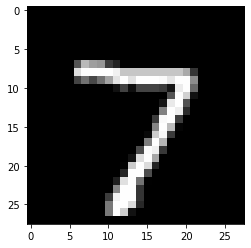

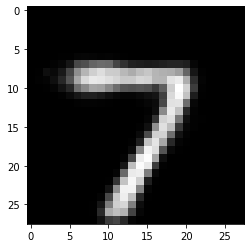

In [41]:
idx = 0
tmp = vae.predict(x_test[0:32].reshape(-1, 28*28))

# true image
plt.imshow(x_test[idx].reshape(28,28), cmap="gray")
plt.show()

# VAE image
plt.imshow(tmp[idx].reshape(28,28), cmap="gray")
plt.show()

### Image generation

In [42]:
# get latent distribution for each digit
latentVecDict = {}
for i in range(10):
    x_train_tmp = x_train[y_train == i]
    
    a = encoder(x_train_tmp.reshape(-1, 28*28))
    a = toNumpy(a)
    
    mean_mu = a.mean(axis=0)[0:n_z]
    mean_log_signma_sq = a.mean(axis=0)[n_z:]
    
    latentVecDict[i] = {"mu": mean_mu, "log_sigma_sq": mean_log_signma_sq}

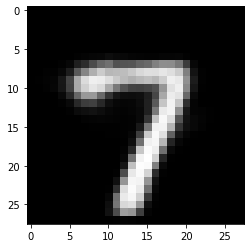

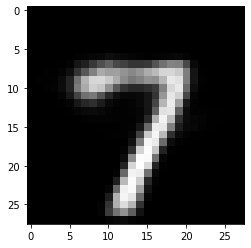

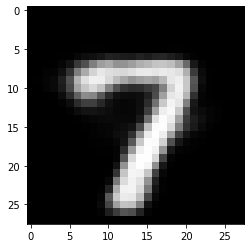

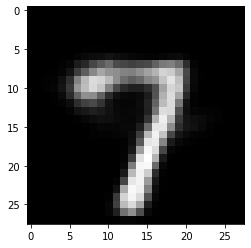

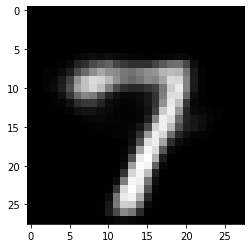

In [45]:
# generate examples
digit = 7
num_example = 5

RN = np.random.normal(0, 1, num_example * n_z).reshape(num_example, n_z)
sample_latent_vec = latentVecDict[digit]["mu"] + np.sqrt(np.exp(latentVecDict[digit]["log_sigma_sq"])) * RN * 1.5

decoderOutput = decoder(sample_latent_vec)
decoderOutput = toNumpy(decoderOutput)

for im in decoderOutput:
    plt.imshow(im.reshape(28, 28), cmap="gray")
    plt.show()